In [1]:
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import io
import os 
from google.colab import files  

In [3]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
openjdk version "11.0.13" 2021-10-19
OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [4]:
!pip install h2o 

In [5]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

In [6]:
uploaded = files.upload()

Saving loan_clean.csv to loan_clean (1).csv


In [7]:
uploaded.keys()

dict_keys(['loan_clean.csv'])

In [8]:
raw = pd.read_csv(io.StringIO(uploaded['loan_clean.csv'].decode('utf-8')))

In [9]:
raw.describe()

,id,bad_loan,GRP_REP_home_ownership,GRP_addr_state,GRP_home_ownership,GRP_purpose,GRP_verification_status,_WARN_,STD_IMP_REP_annual_inc,STD_IMP_REP_delinq_2yrs,STD_IMP_REP_dti,STD_IMP_REP_emp_length,STD_IMP_REP_int_rate,STD_IMP_REP_loan_amnt,STD_IMP_REP_longest_credit_lengt,STD_IMP_REP_revol_util,STD_IMP_REP_term_length,STD_IMP_REP_total_acc
count,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,163987.000000,0.0,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05,1.639870e+05
mean,91994.000000,0.192595,2.574003,11.409337,2.574003,3.244940,2.340356,NaN,2.387342e-11,2.408736e-12,6.806950e-11,-3.563309e-11,-8.939301e-12,8.310596e-11,5.061841e-11,-1.473947e-11,-1.500741e-10,8.045720e-13
std,47339.113634,0.394338,0.667526,9.971926,0.667526,2.267289,0.504086,NaN,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,10001.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,-1.767456e+00,-3.921962e-01,-2.119639e+00,-1.621390e+00,-1.907046e+00,-1.587129e+00,-2.224451e+00,-2.164541e+00,-5.164956e-01,-2.058862e+00
25%,50997.500000,0.000000,2.000000,3.000000,2.000000,2.000000,2.000000,NaN,-6.595203e-01,-3.921962e-01,-7.380602e-01,-7.663281e-01,-6.840838e-01,-7.667612e-01,-7.212383e-01,-7.235035e-01,-5.164956e-01,-7.471426e-01
50%,91994.000000,0.000000,3.000000,8.000000,3.000000,2.000000,2.000000,NaN,-2.225562e-01,-3.921962e-01,-2.257573e-02,8.873407e-02,-5.191344e-02,-2.114351e-01,-1.199531e-01,7.707309e-02,-5.164956e-01,-1.350069e-01
75%,132990.500000,0.000000,3.000000,17.000000,3.000000,3.000000,3.000000,NaN,3.686305e-01,-3.921962e-01,6.955785e-01,1.228817e+00,5.917510e-01,6.215541e-01,4.813321e-01,7.815805e-01,-5.164956e-01,5.645768e-01
max,173987.000000,1.000000,5.000000,37.000000,5.000000,14.000000,3.000000,NaN,4.618062e+00,4.156695e+00,3.037149e+00,1.228817e+00,2.837680e+00,2.767132e+00,3.143160e+00,3.036350e+00,1.971879e+00,3.068467e+00


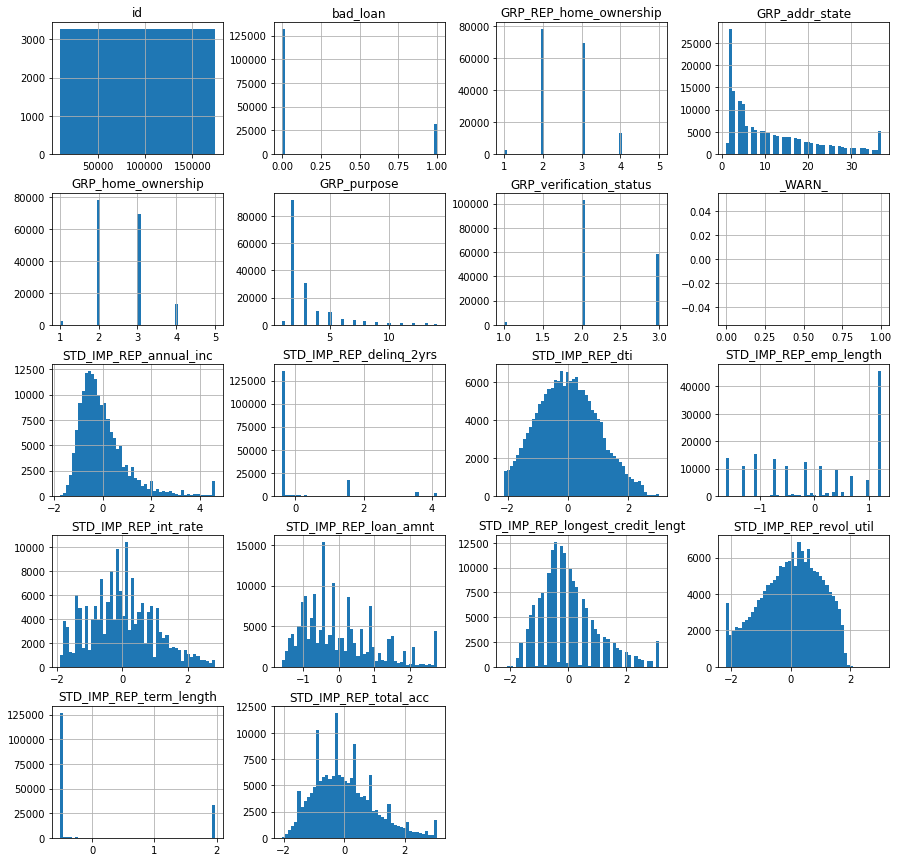

In [10]:
_ = raw[raw.columns].hist(bins=50, figsize=(15, 15))

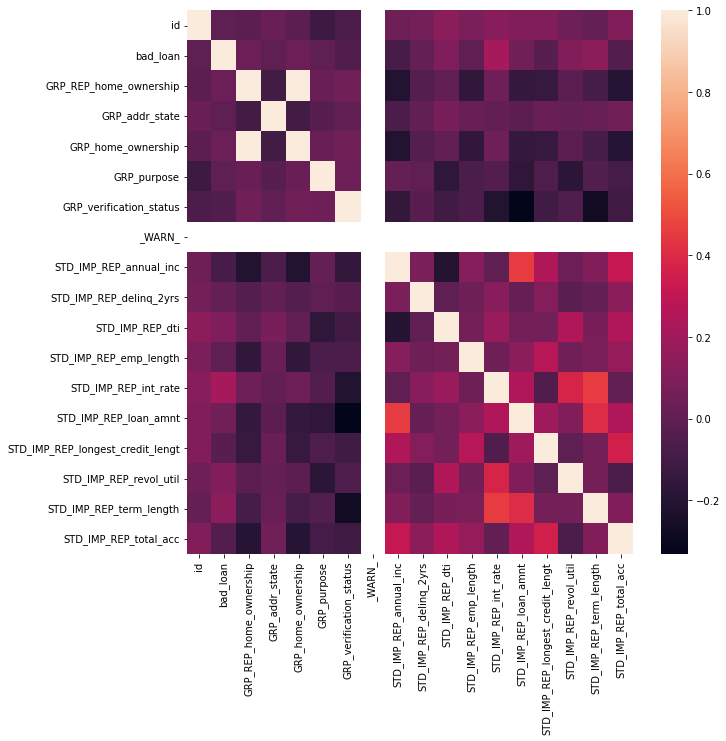

In [11]:
corr = raw.corr()
plt.figure(figsize=(10, 10))
_ = sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

In [12]:
x_names = ["GRP_REP_home_ownership", "GRP_addr_state", 
"GRP_purpose", "GRP_verification_status", "STD_IMP_REP_annual_inc",
"STD_IMP_REP_delinq_2yrs", "STD_IMP_REP_dti", "STD_IMP_REP_emp_length",
"STD_IMP_REP_int_rate", "STD_IMP_REP_loan_amnt",
"STD_IMP_REP_longest_credit_lengt", "STD_IMP_REP_revol_util",
"STD_IMP_REP_term_length", "STD_IMP_REP_total_acc"]
y_name = 'bad_loan'

In [13]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpw365a_9z
  JVM stdout: /tmp/tmpw365a_9z/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpw365a_9z/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_3l5rvz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [14]:
def glm_grid(x_names, y_name, htrain, hvalid=None, seed_=12345):

    """ Wrapper function for penalized GLM with alpha and lambda search.
    :param x_names: List of inputs.
    :param y_name: Name of target variable.
    :param htrain: Training H2OFrame.
    :param hvalid: Validation H2OFrame, default None.
    :param seed_: Random seed for better reproducibility, default 12345.
    :return: Best H2OGeneralizedLinearEstimator.
    """

    alpha_opts = [0.01, 0.25, 0.5, 0.99]  

    # define search criteria
    # i.e., over alpha
    # lamda search handled by lambda_search param below
    hyper_parameters = {'alpha': alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family="binomial",
                                      lambda_search=True,
                                      seed=seed_),
        hyper_params=hyper_parameters)

    # execute training w/ grid search
    grid.train(y=y_name,
               x=x_names,
               training_frame=htrain,
               validation_frame=hvalid,
               seed=seed_)

    # select best model from grid search
    best_model = grid.get_grid()[0]
    del grid

    return best_model

In [15]:
train = h2o.H2OFrame(raw)
train[y_name] = train[y_name].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
loan_glm=glm_grid(x_names, y_name, train, hvalid=None, seed_=12345)

glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.7/dist-packages/h2o/grid/grid_search.py:427: UserWarning: Adding alpha array to hyperparameter runs slower with gridsearch. This is due to the fact that the algo has to run initialization for every alpha value. Setting the alpha array as a model parameter will skip the initialization and run faster overall.
  warnings.warn(w_message)


In [17]:
print('Model parameters:')
for name, val in loan_glm.coef().items():
    print(name + ':', val)
print()

Model parameters:
Intercept: -1.6674288949522607
GRP_REP_home_ownership: 0.05141784848056818
GRP_addr_state: -0.0021362779538869722
GRP_purpose: 0.02654487017363923
GRP_verification_status: -0.031662109727201154
STD_IMP_REP_annual_inc: -0.22499358162642524
STD_IMP_REP_delinq_2yrs: 0.017391027679952722
STD_IMP_REP_dti: 0.14304222277838258
STD_IMP_REP_emp_length: -0.00985020949106613
STD_IMP_REP_int_rate: 0.39245459250976994
STD_IMP_REP_loan_amnt: 0.08583408407021786
STD_IMP_REP_longest_credit_lengt: 0.01018959921410591
STD_IMP_REP_revol_util: 0.08782326764993052
STD_IMP_REP_term_length: 0.1278139935407737
STD_IMP_REP_total_acc: -0.10475492968099663



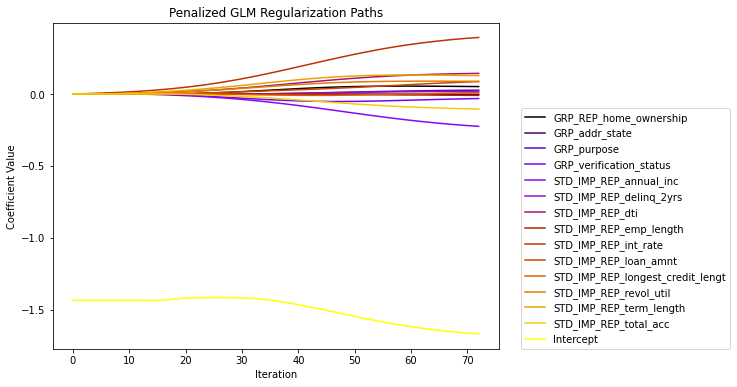

In [18]:
# view trace plot

# collect regularization paths from dict in DataFrame
reg_path_dict = loan_glm.getGLMRegularizationPath(loan_glm)
reg_path_frame = pd.DataFrame(columns=reg_path_dict['coefficients'][0].keys())
for i in range(0, len(reg_path_dict['coefficients'])): 
    reg_path_frame = reg_path_frame.append(reg_path_dict['coefficients'][i], 
                                           ignore_index=True)

glm_selected = list(reg_path_frame.iloc[-1, :][reg_path_frame.iloc[-1, :].abs() > 0.0001].index)

# plot regularization paths
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = reg_path_frame[glm_selected].plot(kind='line', ax=ax_, title='Penalized GLM Regularization Paths',
                                      colormap='gnuplot')
_ = ax_.set_xlabel('Iteration')
_ = ax_.set_ylabel('Coefficient Value')
_ = plt.legend(bbox_to_anchor=(1.05, 0),
               loc=3, 
               borderaxespad=0.)

In [19]:
most_important = 'STD_IMP_REP_int_rate'

In [20]:
print('AUC: %.4f' % loan_glm.auc())

AUC: 0.6789


In [21]:
raw['P_bad_loan'] = loan_glm.predict(train)['p1'].as_data_frame() # place prediction into a Pandas Dataframe
raw[[y_name, 'P_bad_loan']].head(n=10) # view actual vs. predicted

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,bad_loan,P_bad_loan
0,0,0.228377
1,1,0.245866
2,0,0.278425
3,0,0.171208
4,0,0.131085
5,0,0.289813
6,1,0.379009
7,1,0.287796
8,0,0.200557
9,0,0.139713


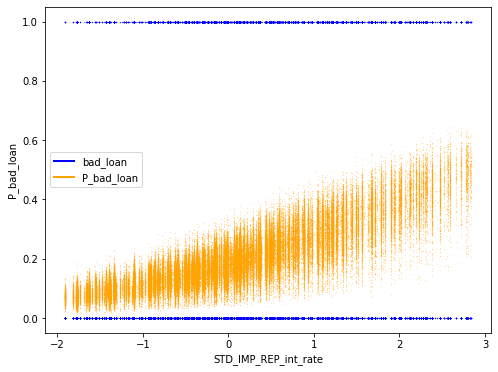

In [22]:
# display y vs. yhat for visual evaluation
fig, ax_ = plt.subplots(figsize=(8, 6))
_ = raw.plot(kind='scatter', x=most_important, y=y_name, s=0.01, color='blue', ax=ax_)
_ = raw.plot(kind='scatter', x=most_important, y='P_bad_loan', s=0.01, color='orange', ax=ax_)

# add custom legend
from matplotlib.lines import Line2D 
custom_lines = [Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
_ = ax_.legend(custom_lines, [y_name, 'P_bad_loan'])

In [23]:
new_row = h2o.H2OFrame({
  "GRP_REP_home_ownership":3 ,
  "GRP_addr_state":20 ,
  "GRP_purpose":5 ,
  "GRP_verification_status":3 ,
  "STD_IMP_REP_annual_inc":1 ,
  "STD_IMP_REP_delinq_2yrs":5 ,
  "STD_IMP_REP_dti": 3,
  "STD_IMP_REP_emp_length":-2 ,
  "STD_IMP_REP_int_rate":4 ,
  "STD_IMP_REP_loan_amnt":3 ,
  "STD_IMP_REP_longest_credit_lengt":4 ,
  "STD_IMP_REP_revol_util":3 ,
  "STD_IMP_REP_term_length":3 ,
  "STD_IMP_REP_total_acc":-2 
}) 
loan_glm.predict(new_row)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.179885,0.820115


In [24]:
h2o.cluster().shutdown()

H2O session _sid_8540 closed.
